# Objectives

1. Plot Locus Coverage of Whole Genome.
1. Add Locus Coverage to Dataframe.
1. Plot Locus Coverage: Distribution.
1. Plot Locus Coverage: Phlyo.
1. Identify Interesting Samples.

---
# Setup

## Imports

In [263]:
import os
import dill
from Bio import Phylo
import copy
import math
import pandas as pd
from matplotlib import lines, patches, colors, gridspec
import seaborn as sns

## Variables

In [35]:
from config import *

# Custom script variables
SCRIPT_NAME = "locus_coverage_collect"
PREV_DIR_NAME = "mugration"
PREV_SCRIPT_NAME = "mugration_model"

try:
    WILDCARDS = snakemake.wildcards
    project_dir = os.getcwd()
except NameError:
    WILDCARDS = ["all", "chromosome", "50"]
    project_dir = os.path.dirname(os.path.dirname(os.getcwd()))
READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
MISSING_DATA = WILDCARDS[2]

NAME_COL = "Sample"

pd.set_option("display.max_rows", 10, "display.max_columns", 10)

## File Paths

In [41]:
config_dir = os.path.join(project_dir, "config")
results_dir = os.path.join(project_dir, "results")


outdir       = os.path.join(results_dir, SCRIPT_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA),)
tree_dill    = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA),PREV_SCRIPT_NAME + "_timetree.treetime.obj")
tree_df_dill = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + ".df.obj")
tree_df_path = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + ".tsv")
aln_path     = os.path.join(results_dir,"snippy_multi",READS_ORIGIN,"snippy-core_{}.snps.filter{}.aln".format(LOCUS_NAME, MISSING_DATA))

# Auspice
auspice_latlon_path = os.path.join(results_dir, "parse_tree", READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), "parse_tree" + "_latlon.tsv")
auspice_colors_path = os.path.join(results_dir, "parse_tree", READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), "parse_tree" + "_colors.tsv")
auspice_config_path = os.path.join(config_dir, "auspice_config.json")
auspice_remote_dir_path = os.path.join(project_dir, "auspice/")

# Uniq
cov_df_path  = os.path.join(results_dir, SCRIPT_NAME, READS_ORIGIN, "locus_coverage" + ".txt")
dep_df_path  = os.path.join(results_dir, SCRIPT_NAME, READS_ORIGIN, "locus_depth" + ".txt")

print("tree_dill:\t", tree_dill)
print("tree_df_dill:\t", tree_df_dill)
print("aln path:\t", aln_path)
print("auspice_latlon_path:", auspice_latlon_path)
print("auspice_colors_path:", auspice_colors_path)
print("auspice_config_path:", auspice_config_path)
print("auspice_remote_dir_path:", auspice_remote_dir_path)
print("outdir:", outdir)

# Create output directory if it doesn't exist
while not os.path.exists(outdir):
    os.makedirs(outdir)   
    
SCRIPT_NAME = "locus_coverage_collect"

tree_dill:	 /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/mugration/all/chromosome_filter50/mugration_model_timetree.treetime.obj
tree_df_dill:	 /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/mugration/all/chromosome_filter50/mugration_model.df.obj
aln path:	 /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/snippy_multi/all/snippy-core_chromosome.snps.filter50.aln
auspice_latlon_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/parse_tree/all/chromosome_filter50/parse_tree_latlon.tsv
auspice_colors_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/parse_tree/all/chromosome_filter50/parse_tree_colors.tsv
auspice_config_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/config/auspice_config.json
auspice_remote_dir_path: /mnt/c/Users/ktmea/Projects/plague-phylogeography/auspice/
outdir: /mnt/c/Users/ktmea/Projects/plague-phylogeography/results/locus_coverage_collect/all/chromosome_filter50


## Import Tree

In [16]:
with open(tree_dill, "rb") as infile:
    tt = dill.load(infile)
tt.tree.ladderize(reverse=False)

## Import Dataframe

In [17]:
with open(tree_df_dill, "rb") as infile:
    tree_df = dill.load(infile)
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_num_date_confidence,timetree_num_date_bar,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad,Mugration_Branch_Number,Mugration_Branch_Number_Confidence,Mugration_Branch_Number_Entropy,Mugration_Branch_Major,Mugration_Branch_Major_Confidence,Mugration_Branch_Major_Entropy,Mugration_Branch_Minor,Mugration_Branch_Minor_Confidence,Mugration_Branch_Minor_Entropy,Mugration_Country,Mugration_Country_Confidence,Mugration_Country_Entropy,Mugration_Country_Lat,Mugration_Country_Lon,Mugration_Province,Mugration_Province_Confidence,Mugration_Province_Entropy,Mugration_Province_Lat,Mugration_Province_Lon
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,NA,NA,0.000000e+00,black,2.148815e-07,2.25,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.942141e-08,1.000000,2.148815e-07,0855-09-28,855.740923,"[855.7409234792349, 855.7409234792349]","[1165.2590765207651, 1165.2590765207651]",0.100000,0.100000,2.25,855.740923,0.000000,False,1,0.379404,1.08856,1.ORI,0.379404,1.08856,1.ORI1,0.379404,1.08856,Russia,0.379404,1.08856,64.6863,97.7453,Rostov Oblast,0.379404,1.08856,47.6222,40.7958
GCA_009909635.1_ASM990963v1_genomic,NA,NA,2.447080e-05,grey,2.278202e-05,1.00,9_10,1923,-98,Russia,Rostov Oblast,64.6863,97.7453,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,2.052208e-08,1.056673,2.256714e-05,1938-03-30,1938.242634,"[1923.0, 1923.0]","[98.0, 98.0]",1082.501711,1082.601711,1.00,1923.000000,0.000023,False,2,1,-1.00009e-12,2.MED,1,-1.00009e-12,2.MED1,1,-1.00009e-12,Russia,1,-1.00009e-12,64.6863,97.7453,Rostov Oblast,1,-1.00009e-12,47.6222,40.7958
Reference,NA,NA,2.307300e-05,grey,2.149205e-05,2.00,NA,1992,-29,United States of America,Colorado,39.7837,-100.446,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,NA,KEEP: Assembly Modern Reference,1,1.821491e-08,0.937878,2.127716e-05,1996-07-12,1996.529295,"[1992.0, 1992.0]","[29.0, 29.0]",1140.788371,1140.888371,2.00,1992.000000,0.000021,False,1,1,-1.00009e-12,1.ORI,1,-1.00009e-12,1.ORI1,1,-1.00009e-12,United States of America,1,-1.00009e-12,39.7837,-100.446,Colorado,1,-1.00009e-12,38.7252,-105.608
NODE1,91,0,2.721210e-05,black,2.536025e-05,3.50,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,2.136642e-08,1.100148,2.514537e-05,2005-09-05,2005.678813,"[1985.457689492314, 2005.0]","[35.5423105076859, 16.0]",1149.937889,1150.037889,3.50,2005.678813,0.000025,False,0,0.875959,0.460385,0.ANT,0.875959,0.460385,0.ANT1,0.875959,0.460385,China,0.875959,0.460385,35.0001,105,Xinjiang,0.875959,0.460385,42.4805,85.4633
GCA_009669545.1_ASM966954v1_genomic,NA,NA,2.330000e-08,grey,2.536025e-05,3.00,42126,2006,-15,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,5.812589e-09,0.299288,2.828252e-18,2008-05-10,2008.355574,"[2006.0, 2006.0]","[15.0, 15.0]",2.676761,1152.714650,3.00,2006.000000,0.000025,False,0,1,-9.99867e-13,0.ANT,1,-9.99867e-13,0.ANT1,1,-9.99867e-13,China,1,-1.00009e-12,35.0001,105,Xinjiang,1,-1.00009e-12,42.4805,85.4633
GCA_009669555.1_ASM966955v1_genomic,NA,NA,2.331000e-07,grey,2.557514e-05,4.00,42123,2005,-16,China,Xinjiang,35.0001,105,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,3.247561e-08,1.672155,2.148899e-07,2007-07-06,2007.510839,"[2005.0, 2005.0]","[16.0, 16.0]",1.832026,1151.869916,4.00,2005.000000,0.000025,False,0,1,-9.99867e-13,0.ANT,1,-9.99867e-13,0.ANT1,1,-9.99867e-13,China,1,-1.00009e-12,35.0001,105,Xinjiang,1,-1.00009e-12,42.4805,85.4633


## Import Locus Dataframes

In [354]:
cov_df = pd.read_csv(cov_df_path, sep='\t')
cov_df.set_index(NAME_COL, inplace=True)
cov_df_samples = cov_df.index

dep_df = pd.read_csv(dep_df_path, sep='\t')
dep_df.set_index(NAME_COL, inplace=True)
dep_df_samples = dep_df.index

# Remove samples not in tree dataframe
for sample in cov_df_samples:
    if sample not in tree_df.index:
        cov_df.drop(sample, inplace=True)
        dep_df.drop(sample, inplace=True)
        
display(cov_df)        
display(dep_df)

,AL590842.1:1..4653728,gene-YPO0001,cds-CAL18691.1,gene-YPO0002,cds-CAL18692.1,...,gene-YPPCP1.08c,cds-CAB53171.1,gene-YPPCP1.09c,cds-CAB53172.1,id-AL109969.1:8528..8532
Sample,,,,,,,,,,,
GCA_009909635.1_ASM990963v1_genomic,0.919553,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0
GCA_009669545.1_ASM966954v1_genomic,0.947885,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0
GCA_009669555.1_ASM966955v1_genomic,0.945635,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0


,AL590842.1:1..4653728,gene-YPO0001,cds-CAL18691.1,gene-YPO0002,cds-CAL18692.1,...,gene-YPPCP1.08c,cds-CAB53171.1,gene-YPPCP1.09c,cds-CAB53172.1,id-AL109969.1:8528..8532
Sample,,,,,,,,,,,
GCA_009909635.1_ASM990963v1_genomic,18.131132,20.0,20.0,20.0,20.0,...,0.0,0.0,0.0,0.0,0.000000
GCA_009669545.1_ASM966954v1_genomic,18.714769,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.000000
GCA_009669555.1_ASM966955v1_genomic,18.661659,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,19.200001


## Separate Dataframe into Replicons and Genes

In [355]:
replicon_cov_df = copy.deepcopy(cov_df)
replicon_loci = []
non_replicon_loci = []

for col in cov_df.columns:
    #if (":" not in col) or ("id" in col) or ("rna" in col) or ("exon" in col):
    if (":" in col) and ("id" not in col) and ("rna" not in col) and ("exon" not in col):
        replicon_loci.append(col)
    else:
        non_replicon_loci.append(col)

replicon_cov_df.drop(columns=non_replicon_loci, inplace=True)
display(replicon_cov_df)

#replicon_dep_df = copy.deepcopy(dep_df)
#replicon_dep_df.drop(columns=drop_loci, inplace=True)
#display(replicon_dep_df)

,AL590842.1:1..4653728,AL117189.1:1..70305,AL117211.1:1..96210,AL109969.1:1..9612
Sample,,,,
GCA_009909635.1_ASM990963v1_genomic,0.919553,0.919181,0.938385,0.000000
GCA_009669545.1_ASM966954v1_genomic,0.947885,0.941384,0.941461,0.800666
GCA_009669555.1_ASM966955v1_genomic,0.945635,0.931143,0.940838,0.800250


## Import Colors

In [356]:
colors_df = pd.read_csv(auspice_colors_path, sep='\t', header=None)
colors_df.columns = ["Attribute", "State", "Color"]
colors_df.fillna(NO_DATA_CHAR, inplace=True)
display(colors_df)

colors_dict = {}
# Convert to dict

for rec in colors_df.iterrows():
    attr = rec[1]["Attribute"]
    state = rec[1]["State"]
    color = rec[1]["Color"]
    if attr not in colors_dict:
        colors_dict[attr] = {}
    colors_dict[attr][state] = color

,Attribute,State,Color
0,branch_number,2.0,#8000ff
1,branch_number,1,#80ffb4
2,branch_number,0.0,#ff0000
3,branch_major,2.MED,#8000ff
4,branch_major,1.ORI,#80ffb4
...,...,...,...
10,country,United States of America,#80ffb4
11,country,China,#ff0000
12,province,Rostov Oblast,#8000ff
13,province,Colorado,#80ffb4


---
# 1. Plot Locus Coverage of Whole Genome

## Create a sub dataframe with plotting coordinates

In [357]:
# X is the positional index of the loci
# Y is the samples y coord in the tree
# D is the data about the loci

#i = 1
s = []
x = []
y = []
d = []
r = []

replicon_dict = {}

#for loci in replicon_cov_df:
#for loci in cov_df.columns[0:5000]:
for loci in cov_df.columns:
    if loci in replicon_loci:
        i = 1
        replicon_dict[loci] = i
        replicon = loci
    for sample in cov_df.index:
        s.append(sample)
        x.append(i)
        y.append(tree_df["coord_y"][sample])
        d.append(cov_df[loci][sample])
        r.append(replicon)
    i += 1
    
# Create a dataframe
df = pd.DataFrame({"x":x,"y":y,"data":d, "sample" : s, "replicon": r})
display(df)

,x,y,data,sample,replicon
0,1,1.0,0.919553,GCA_009909635.1_ASM990963v1_genomic,AL590842.1:1..4653728
1,1,3.0,0.947885,GCA_009669545.1_ASM966954v1_genomic,AL590842.1:1..4653728
2,1,4.0,0.945635,GCA_009669555.1_ASM966955v1_genomic,AL590842.1:1..4653728
3,2,1.0,1.000000,GCA_009909635.1_ASM990963v1_genomic,AL590842.1:1..4653728
4,2,3.0,1.000000,GCA_009669545.1_ASM966954v1_genomic,AL590842.1:1..4653728
...,...,...,...,...,...
56629,29,3.0,1.000000,GCA_009669545.1_ASM966954v1_genomic,AL109969.1:1..9612
56630,29,4.0,1.000000,GCA_009669555.1_ASM966955v1_genomic,AL109969.1:1..9612
56631,30,1.0,0.000000,GCA_009909635.1_ASM990963v1_genomic,AL109969.1:1..9612
56632,30,3.0,1.000000,GCA_009669545.1_ASM966954v1_genomic,AL109969.1:1..9612


## Setup the Timetree

0.5
0.5
0.5
0.5


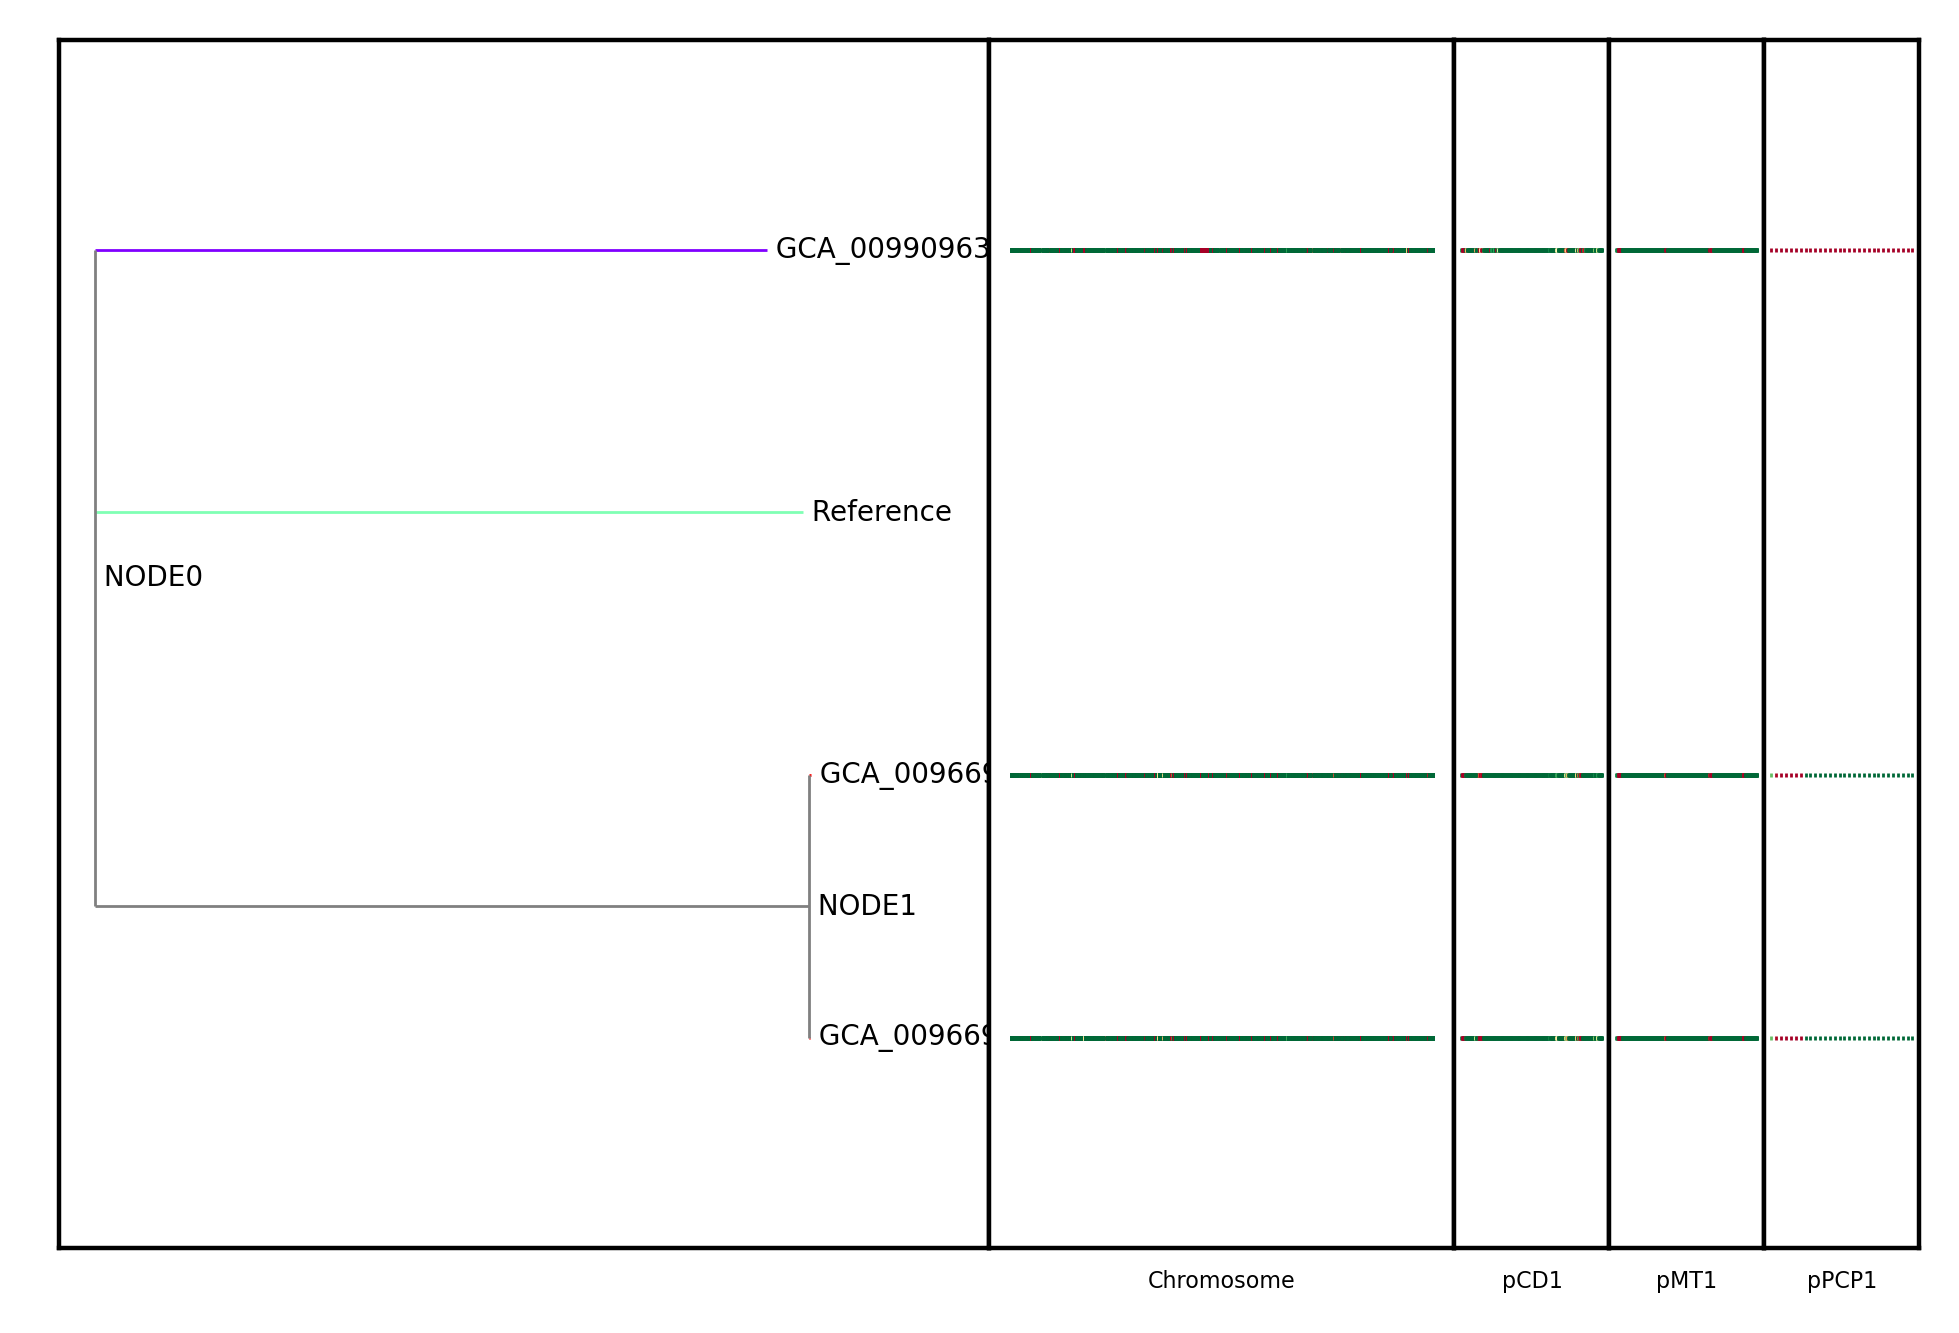

In [385]:
#fig, axes = plt.subplots(1, len(replicon_loci) + 1, dpi=dpi, sharey=True)   
# ax1 = axes[0]
fig_rep = plt.figure(figsize=(6,4), dpi=dpi)
axes_dict = {
    "Tree" : {
        "prop" : 6,
    },
    "AL590842.1:1..4653728" : {
        "prop" : 3,
        "label" : "Chromosome",
    },
    "AL117189.1:1..70305": {
        "prop" : 1,
        "label" : "pCD1",        
    },
    "AL117211.1:1..96210": {
        "prop" : 1,
        "label" : "pMT1",        
    },
    "AL109969.1:1..9612": {
        "prop" : 1,
        "label" : "pPCP1",        
    },
}


total_col = sum([axes_dict[ax]["prop"] for ax in axes_dict])
gs = gridspec.GridSpec(1, total_col, figure=fig_rep, wspace=0, hspace=0)

axes = []
i_prev = 0
for ax in axes_dict:
    i_cur = i_prev + axes_dict[ax]["prop"]
    if len(axes) > 0:
        axes += [fig_rep.add_subplot(gs[0, i_prev:i_cur], sharey=axes[0])]
    else:
        axes += [fig_rep.add_subplot(gs[0, i_prev:i_cur],)]
    i_prev = i_cur
    
for ax in fig_rep.get_axes():
    ax.set_yticks([])
    ax.set_xticks([])
    
# ---------------------------------------
# Phylogeny
tt_copy = copy.deepcopy(tt)

# Setup color
for c in tt_copy.tree.find_clades():
    state = tree_df["Mugration_Branch_Major"][c.name]
    state_conf = tree_df["Mugration_Branch_Major_Confidence"][c.name]
    color = colors_dict["branch_major"][state]
    # Reset to grey low confidence
    c.color = "grey"
    if state_conf >= MUG_CONF_THRESH:
        c.color = color

# Phylogeny Lines
Phylo.draw(tt_copy.tree,
           axes=axes[0],
           show_confidence=False, 
           label_func = lambda x:x, 
           do_show=False,
          )
axes[0].set_xlabel("")
axes[0].set_ylabel("")

# ---------------------------------------
# Heatmaps

# Create the Color map
cmap = plt.cm.RdYlGn
norm = colors.Normalize(vmin=min(d), vmax=max(d))
ax_i = 0

for component in axes_dict:
    if component == "Tree": continue
    ax_i += 1
    rep_df = df[df["replicon"] == component]
    marker_size=0.50
    #marker_size = 1000/max(rep_df["x"])
    print(marker_size)
    axes[ax_i].scatter(rep_df.x, 
                rep_df.y, 
                color=cmap(norm(rep_df["data"].values)),
                marker="|",
                s=marker_size)   
    axes[ax_i].set_xticks([])
    axes[ax_i].set_yticks([])
    axes[ax_i].set_xlabel(axes_dict[component]["label"], fontsize=4)

In [316]:
#fig, axes = plt.subplots(1, len(replicon_loci) + 1, dpi=dpi, sharey=True)   
# ax1 = axes[0]

fig_rep = plt.figure(figsize=(6,4), dpi=dpi)

# Proportions
# Tree : 6
# Chrom : 3
# pCD1 : 1
# pMT1 : 1
# pPCP1 : 1
axes_dict_dict = {
    "Tree" : 6,
    "AL590842.1:1..4653728" : 3,
    "AL117189.1:1..70305": 1,
    "AL117211.1:1..96210": 1,
    "AL109969.1:1..9612": 1,
},
"""
for replicon in replicon_dict:
    print(replicon)

# Setup the grid
gs = gridspec.GridSpec(1, 12, figure=fig, wspace=0, hspace=0)
axes = [fig_rep.add_subplot(gs[0, 0:6])] # Tree axis
axes += [fig_rep.add_subplot(gs[0, 6:9])] # Chromosome axis
axes += [fig_rep.add_subplot(gs[0, 9:10])] # pCD1 axis
axes += [fig_rep.add_subplot(gs[0, 10:11])] # pMT1 axis
axes += [fig_rep.add_subplot(gs[0, 11:12])] # pPCP1 axis

for ax in fig_rep.get_axes():
    ax.spines['top'].set_visible(ax.is_first_row())
    ax.spines['bottom'].set_visible(ax.is_last_row())
    #ax.spines['left'].set_visible(ax.is_first_col())
    #ax.spines['right'].set_visible(ax.is_last_col())
    ax.set_yticks([])
    ax.set_xticks([])
    
# ---------------------------------------
# Phylogeny

tt_copy = copy.deepcopy(tt)
# Setup color
for c in tt_copy.tree.find_clades():
    state = tree_df["Mugration_Branch_Major"][c.name]
    state_conf = tree_df["Mugration_Branch_Major_Confidence"][c.name]
    color = colors_dict["branch_major"][state]
    # Reset to grey low confidence
    c.color = "grey"
    if state_conf >= MUG_CONF_THRESH:
        c.color = color

# Phylogeny Lines
Phylo.draw(tt_copy.tree,
           axes=axes[0],
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False,
          )
axes[0].set_xlabel("")
axes[0].set_ylabel("")

# ---------------------------------------
# Heatmap

cmap = plt.cm.RdYlGn
norm = colors.Normalize(vmin=min(d), vmax=max(d))
ax_i = 0
for replicon in replicon_dict:
    ax_i += 1
    rep_df = df[df["replicon"] == replicon]
    #display(rep_df)
    marker_size = 10 / len(rep_df.columns),
    axes[ax_i].scatter(rep_df.x, 
                rep_df.y, 
                color=cmap(norm(rep_df["data"].values)),
                marker="|",
                s=marker_size)   
    axes[ax_i].set_xticks([])
    axes[ax_i].set_yticks([])
    axes[ax_i].set_xlabel(replicon, fontsize=4)
    
#marker_size = 25 / max(x)

ax2.scatter(df.x, 
            df.y, 
            color=cmap(norm(df.data.values)),
            marker="s",
            s=marker_size)

# Draw lines for replicons
for replicon in r:
    ax2.axvline(x=r[replicon] -1, color="black", linestyle="-", alpha=0.75)

#fig.tight_layout(pad=1)
#ax1.set_ylim(0,10)"""

'\nfor replicon in replicon_dict:\n    print(replicon)\n\n# Setup the grid\ngs = gridspec.GridSpec(1, 12, figure=fig, wspace=0, hspace=0)\naxes = [fig_rep.add_subplot(gs[0, 0:6])] # Tree axis\naxes += [fig_rep.add_subplot(gs[0, 6:9])] # Chromosome axis\naxes += [fig_rep.add_subplot(gs[0, 9:10])] # pCD1 axis\naxes += [fig_rep.add_subplot(gs[0, 10:11])] # pMT1 axis\naxes += [fig_rep.add_subplot(gs[0, 11:12])] # pPCP1 axis\n\nfor ax in fig_rep.get_axes():\n    ax.spines[\'top\'].set_visible(ax.is_first_row())\n    ax.spines[\'bottom\'].set_visible(ax.is_last_row())\n    #ax.spines[\'left\'].set_visible(ax.is_first_col())\n    #ax.spines[\'right\'].set_visible(ax.is_last_col())\n    ax.set_yticks([])\n    ax.set_xticks([])\n    \n# ---------------------------------------\n# Phylogeny\n\ntt_copy = copy.deepcopy(tt)\n# Setup color\nfor c in tt_copy.tree.find_clades():\n    state = tree_df["Mugration_Branch_Major"][c.name]\n    state_conf = tree_df["Mugration_Branch_Major_Confidence"][c.name]

<Figure size 2400x1600 with 0 Axes>

---
# 1. Add Locus Info to Dataframe

In [ ]:
for locus in locus_df.columns:
    tree_df[locus] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
    for i in range(0, len(locus_df[locus])):
        sample = locus_df.index[i]
        if sample not in tree_df.index: continue
        cov = locus_df[locus][i]
        tree_df.at[sample, locus] = cov

display(tree_df)


In [ ]:
# add ratios
locus = ["pPCP1"]
gene = ["pla"]

for l,g in zip(locus, gene):
    ratio_col = l + "_" + g + "_dep_ratio"
    tree_df[ratio_col] = [NO_DATA_CHAR for row in range(0,len(tree_df))]
    ratio_df = locus_df[[l + "_dep", g + "_dep"]]
    for rec in ratio_df.iterrows():
        sample = rec[0]
        l_dep = rec[1][l + "_dep"]
        g_dep = rec[1][g + "_dep"]
        if l_dep == 0 or g_dep == 0 or l_dep < 10:
            ratio = NO_DATA_CHAR
        else:
            ratio = l_dep / g_dep
        tree_df.at[sample,ratio_col] = ratio
        
display(tree_df)

---
# 2. Plot Locus Distributions: Histogram

In [ ]:
fig, axes = plt.subplots(2,1, dpi=dpi, figsize=(4,3), sharex=True)
covs = axes[0].violinplot(
    dataset=[locus_cov_df[col] * 100 for col in locus_cov_df.columns],
    #dataset=[cov_data[col] * 100 for col in cov_data.columns],
    #showmeans=True,
    showmedians=False,
    showextrema=False,
)  


deps = axes[1].violinplot(
    dataset=locus_dep_df, 
    #showmeans=True,
    showmedians=False,
    showextrema=False,
)    

labels = [NO_DATA_CHAR] + [locus.split("_")[0] for locus in locus_cov_df.columns if "cov" in locus]
axes[1].set_xticklabels(labels, fontsize=4)

axes[0].set_ylabel("Genomic Coverage (%)", fontsize=4)
axes[1].set_ylabel("Genomic Depth (X)", fontsize=4)
axes[1].set_ylim(-2,50)

for cov,dep in zip(covs["bodies"], deps["bodies"]):
    cov.set_linewidth(1)
    dep.set_facecolor('#D43F3A')    
    cov.set_alpha(0.8); dep.set_alpha(0.8)
    cov.set_linewidth(0.5); dep.set_linewidth(0.5)
    cov.set_edgecolor('black'); dep.set_edgecolor('black')
    
out_path = os.path.join(outdir, SCRIPT_NAME + "_summary." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

---
# 3. Plot Locus Coverage: Phylo

In [ ]:
# Plot setup
fig, ax1 = plt.subplots(1, dpi=dpi)

# Colors Setup
attr = "Branch_Major"
attr_lower = attr.lower()
attr_colors_df = colors_df[colors_df["Attribute"] == attr_lower][["State","Color"]]
attr_colors_dict = {}
for rec in attr_colors_df.iterrows():
    state = rec[1]["State"]
    color = rec[1]["Color"]
    attr_colors_dict[state] = color

tt_copy = copy.deepcopy(tt)


# --------------------------------------------
# Phylogeny Lines
Phylo.draw(tt_copy.tree,
           axes=ax1,
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False,
          )

# Node Bars
x_min = 0
if hasattr(tt_copy.tree.root, "marginal_inverse_cdf"):
    # Need to invert the node bar units
    present_date = abs(tt_copy.tree.root.numdate - CURRENT_YEAR)
    for rec in tree_df.iterrows():
        conf_bar = rec[1]["timetree_num_date_bar"]
        bar_lower = present_date - conf_bar[0]
        bar_upper = present_date - conf_bar[1]
        y = rec[1]["timetree_coord_y"]
        ax1.plot([bar_lower, bar_upper], [y,y], alpha=0.5, c="grey", linewidth=2)
        
        # Possibly update axis x-limits
        if bar_lower < x_min:
            x_min = bar_lower

# --------------------------------------------
# Phylogeny Scatter
tip_data = tree_df[(tree_df["Branch_Support_Color"] == TERM_COL)]
#ax1.scatter(data=tip_data, x="timetree_coord_x", y="timetree_coord_y", s=0.5, c="grey")

# --------------------------------------------
# Heatmap - Attribute

# Heatmap x coordinates will stay the same
heatmap_x_buffer = max(tree_df["timetree_coord_x"]) * 0.05
heatmap_x1 = max(tree_df["timetree_coord_x"]) + heatmap_x_buffer
heatmap_x2 = heatmap_x1 + (0.5 * heatmap_x_buffer)

for rec in tip_data.iterrows():
    y = rec[1]["timetree_coord_y"]
    state = rec[1][attr]
    color = attr_colors_dict[state]
    ax1.plot([heatmap_x1, heatmap_x2], [y,y], alpha=1, c=color, linewidth=0.5)

# Label
ax1.text(x=heatmap_x1, y=-5, s="Clade", ha="left", rotation=45)

# --------------------------------------------
# Heatmap - Locus Coverage

# Labels
locus_x1 = heatmap_x1
locus_x2 = heatmap_x2        
locus_cov_df = tree_df[tree_df["pCD1_cov"] != NO_DATA_CHAR][["pCD1_cov", "pMT1_cov", "pPCP1_cov"]]


for locus in locus_cov_df.columns:
    locus_x1 = locus_x2 + (0.25 * heatmap_x_buffer)
    locus_x2 = locus_x1 + (0.5 * heatmap_x_buffer)      
    locus_name = locus.split("_")[0]
    ax1.text(x=locus_x1, y=-10, s=locus_name, ha="left", rotation=45)

# Bars

# Black Background
locus_x1 = heatmap_x1
locus_x2 = heatmap_x2 
for locus in locus_cov_df.columns:
    # Update locus coordinates
    locus_x1 = locus_x2 + (0.25 * heatmap_x_buffer)
    locus_x2 = locus_x1 + (0.5 * heatmap_x_buffer)
    rect_x = locus_x1
    rect_y = min(tree_df["timetree_coord_y"])
    rect_width = locus_x2 - locus_x1
    rect_height = max(tree_df["timetree_coord_y"])
    rect = patches.Rectangle(xy=(rect_x, rect_y), width=rect_width, height=rect_height, linewidth=0.5, edgecolor='black', facecolor="black")
    ax1.add_patch(rect)  

# White lines for absence
for rec in locus_cov_df.iterrows():   
    locus_x1 = heatmap_x1
    locus_x2 = heatmap_x2 
    sample = rec[0]
        
    for locus in locus_cov_df.columns:
        locus_x1 = locus_x2 + (0.25 * heatmap_x_buffer)
        locus_x2 = locus_x1 + (0.5 * heatmap_x_buffer)
        
        cov = locus_cov_df[locus][sample]
        y = tree_df["timetree_coord_y"][sample]
        if cov < 0.1: 
            ax1.plot([locus_x1, locus_x2], [y,y], alpha=1, c="white", linewidth=1)
"""
# --------------------------------------------
# Heatmap - pla depth

locus_x1 = locus_x2 + (0.25 * heatmap_x_buffer)
locus_x2 = locus_x1 + (0.5 * heatmap_x_buffer)

# label
ax1.text(x=locus_x1, y=-10, s="pla", ha="left", rotation=45)

dep_df = tree_df[
                   (tree_df[l + "_" + g + "_dep_ratio"] != NO_DATA_CHAR) &
                   (~tree_df["BioSampleComment"].str.contains("Assembly")) &
                   (tree_df["pPCP1_dep"] != NO_DATA_CHAR)
                   ][["pPCP1_dep", "pla_dep", "pPCP1_pla_dep_ratio"]]
dep_df = dep_df[dep_df["pPCP1_dep"] >= 10]

for rec in dep_df.sort_values(by="pPCP1_pla_dep_ratio").iterrows():
    sample = rec[0]
    val = rec[1]["pPCP1_pla_dep_ratio"]
    y = tree_df["timetree_coord_y"][sample]
    if val < (20/15):
        color = "green"
    else:
        color = "red"
    ax1.plot([locus_x1, locus_x2], [y,y], alpha=1, c=color, linewidth=1)

"""
# --------------------------------------------
# Ticks
ticks_dict = convert_timetree_ticks(tree=tt_copy.tree, step=500)
# Set the new tick locations and labels
# Leave out last one
ax1.set_xticks(ticks_dict["tick_locs"][:-1])
ax1.set_xticklabels(ticks_dict["tick_labels"][:-1])

# --------------------------------------------
# Lines
# Vertical lines for dates
for loc in ticks_dict["tick_locs"][:-1]:
    ax1.axvline(x=loc, color="darkgrey", alpha=0.5)

# --------------------------------------------
# Limits

x_buffer = math.ceil((ticks_dict["tick_locs"][-1] - ticks_dict["tick_locs"][0]) * 0.05)
y_buffer = math.ceil(len(tt_copy.tree.get_terminals()) * 0.05)

ax1.set_xlim(0 - x_buffer,)    
ax1.set_ylim(len(tt_copy.tree.get_terminals()) + y_buffer, 0 - y_buffer)
ax1.set_yticks([])    


# --------------------------------------------
# Labels
ax1.set_xlabel("Year")
ax1.set_ylabel("")

# --------------------------------------------
# Frames
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["left"].set_visible(False)

# -------------------------------
# Legend

legend_lines = [lines.Line2D([0], [0], color=attr_colors_dict[state], lw=4) 
                for state in attr_colors_dict]
legend_labels = [state for state in attr_colors_dict]

legend = fig.legend(legend_lines, 
           legend_labels,
           ncol=len(legend_labels),
           loc="center", 
           bbox_to_anchor=(0.5, -0.05),
           #bbox_to_anchor=(0.14,-0.13),
           frameon=True,
           borderpad=1.0,
           edgecolor="black",
           title="Clade",
           title_fontsize=SM_FONT,
           fontsize=4,
          )

locus_patches = [patches.Patch(facecolor="black", edgecolor="black",),
                 patches.Patch(facecolor="white", edgecolor="black",),]

locus_labels = [">=10%", "<10%", ]

locus_legend = fig.legend(locus_patches, 
           locus_labels,
           ncol=len(locus_labels),
           loc="center", 
           bbox_to_anchor=(0.5, -0.15),
           frameon=True,
           borderpad=1.0,
           edgecolor="black",
           title="Plasmid Coverage",
           title_fontsize=SM_FONT
           )

"""gene_patches = [patches.Patch(facecolor="green", edgecolor="black",),
                patches.Patch(facecolor="red", edgecolor="black",),
                patches.Patch(facecolor="white", edgecolor="black",),]
gene_labels = [">= Plasmid Depth", "< Plasmid Depth", "No Sequence Data"]

gene_legend = fig.legend(gene_patches, 
           gene_labels,
           ncol=len(gene_labels),
           loc="center", 
           bbox_to_anchor=(0.75, -0.15),
           frameon=True,
           borderpad=1.0,
           edgecolor="black",
           title="Gene Depth",
           title_fontsize=SM_FONT
           )
"""
# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_phylo." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

---
# 3. Plot Locus vs. Gene Ratio

In [ ]:
dep_df = tree_df[
                   (tree_df[l + "_" + g + "_dep_ratio"] != NO_DATA_CHAR) &
                   (~tree_df["BioSampleComment"].str.contains("Assembly"))
                   ][["pPCP1_dep", "pla_dep", "pPCP1_pla_dep_ratio"]]




fig, ax1 = plt.subplots(1, 1, dpi=dpi, figsize=(3,2))

colors = []
for rec in dep_df.iterrows():
    ratio = rec[1]["pPCP1_pla_dep_ratio"]
    cov = rec[1]["pPCP1_dep"]
    # If coverage is low, ratio doesn't matter
    if cov < 10:
        color = "white"
    elif ratio <= (20/15):
        color = "green"
    else:
        color = "red"
    colors.append(color)

#colors = ["red" if r > (20/15) else "green" for r,c in dep_df[["pPCP1_pla_dep_ratio","pPCP1_dep"]]]
ax1.scatter(x=dep_df["pPCP1_dep"], 
            y=dep_df["pla_dep"], 
            s=10, 
            alpha=0.8, 
            edgecolor="black", 
            linewidth=0.25, 
            color=colors
            )

x = 200
y_norm = x * (20/15)
y_low = x
ax1.plot([0,x], [0,x*(20/15)], color="green", linestyle="--")
#ax1.plot([0,175], [0,225], color="green", linestyle="--")
#ax1.plot([0,x], [0,x/3], color="red", linestyle="--")
ax1.plot([0,x], [0,x * (1/3)], color="red", linestyle="--")


ax1.set_xlabel("Plasmid pPCP1 Depth (X)",fontsize=4)
ax1.set_ylabel("Gene pla Depth (X)",fontsize=4)

ax1.set_xlim(-5,x)
ax1.set_ylim(-10,x*20/15)

#ax1.set_title("Comparison of pPCP1 Depth and pla Depth", fontsize=SM_FONT)

legend_labels = ["Gene >= Plasmid", "Gene < Plasmid", "Low Coverage"]
legend_lines = [
    lines.Line2D([], [], markeredgecolor="black", markerfacecolor='green', markeredgewidth=0.25, marker='.', linestyle='None', markersize=6,),
    lines.Line2D([], [], markeredgecolor="black", markerfacecolor='red', markeredgewidth=0.25, marker='.', linestyle='None', markersize=6,),
    lines.Line2D([], [], markeredgecolor="black", markerfacecolor='white', markeredgewidth=0.25, marker='.', linestyle='None', markersize=6,),    
               ]
"""fig.legend(legend_lines, 
           legend_labels,
           loc='upper left',
           frameon=True,
           edgecolor="black",
          )"""

legend = fig.legend(legend_lines, 
                    legend_labels, 
                    loc='center', 
                    bbox_to_anchor=(0.25, 0.79), 
                    frameon=True, 
                    fontsize=4,
                    edgecolor="black")

legend.get_frame().set_linewidth(0.5)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_pPCP1-pla-depth." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

# ? Export

## Dataframe

In [ ]:
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
out_path_pickle_df = os.path.join(outdir,  SCRIPT_NAME + ".df.obj" )

tree_df.to_csv(out_path_df, sep="\t")
with open(out_path_pickle_df,"wb") as outfile:
    dill.dump(tree_df, outfile)

## Timetrees

In [ ]:
# Phyloxml
tt_copy = copy.deepcopy(tt)
out_path_xml = os.path.join(outdir,  SCRIPT_NAME + "_timetree.xml" )
Phylo.write(tt_copy.tree, out_path_xml, 'phyloxml')

# Nexus
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + "_timetree.nexus" )
Phylo.write(tt_copy.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

# Dill object
out_path_dill_tree = os.path.join(outdir,  SCRIPT_NAME + "_timetree.treetime.obj" )
with open(out_path_dill_tree,"wb") as outfile:
    dill.dump(tt_copy, outfile)
    
# Newick (remove comments)
for c in tt_copy.tree.find_clades(): c.comment = None
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + "_timetree.nwk" )
Phylo.write(tt_copy.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

## Divtrees

In [ ]:
tt_copy = copy.deepcopy(tt)
# Convert to divtree
for n in tt_copy.tree.find_clades():
    n.branch_length=n.mutation_length

# Phyloxml
out_path_xml = os.path.join(outdir,  SCRIPT_NAME + "_divtree.xml" )
Phylo.write(tt_copy.tree, out_path_xml, 'phyloxml')

# Nexus
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + "_divtree.nexus" )
Phylo.write(tt_copy.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

# Dill object
out_path_dill_tree = os.path.join(outdir,  SCRIPT_NAME + "_divtree.treetime.obj" )
with open(out_path_dill_tree,"wb") as outfile:
    dill.dump(tt_copy, outfile)
    
# Newick (remove comments)
for c in tt_copy.tree.find_clades(): c.comment = None
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + "_divtree.nwk" )
Phylo.write(tt_copy.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

## Augur JSON

In [ ]:
augur_dict = augur_export(
    tree_path=out_path_nwk, 
    aln_path=aln_path, 
    tree=tt_copy.tree, 
    tree_df=tree_df, 
    color_keyword_exclude=["color", "coord", "lat", "lon"],
    type_convert = {
        "Branch_Number" : (lambda x : str(x))
    },
)

print(augur_dict["nodes"]["NODE0"])

out_path_augur_json = os.path.join(outdir, SCRIPT_NAME + "_augur.json" )
utils.write_json(data=augur_dict, file_name=out_path_augur_json, indent=JSON_INDENT)

## Auspice JSON

In [ ]:
auspice_dict = auspice_export(
    tree=tt_copy.tree, 
    augur_json_paths=[out_path_augur_json], 
    auspice_config_path=auspice_config_path, 
    auspice_colors_path=auspice_colors_path,
    auspice_latlons_path=auspice_latlon_path, 
    )

# Write outputs - For Local Rendering
out_path_auspice_local_json = os.path.join(outdir, SCRIPT_NAME + "_auspice.json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_local_json)
print("Validation successful for local JSON.")

# Write outputs - For Remote Rendering
out_path_auspice_remote_json = os.path.join(auspice_remote_dir_path, AUSPICE_PREFIX + SCRIPT_NAME.replace("_","-") + ".json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_remote_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_remote_json)
print("Validation successful for remote JSON.")